In [131]:
from collections.abc import Sequence
from functools import partial
import itertools
from time import perf_counter
import math

from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import rotate
from scipy.spatial.distance import euclidean
from scipy.spatial.transform import Rotation
import vedo

from histalign.backend.ccf.paths import get_atlas_path
from histalign.backend.io import load_volume
from histalign.backend.maths import compute_centre, compute_normal_from_raw
from histalign.backend.models import (
    Orientation,
    Resolution,
)
from histalign.backend.models.errors import InvalidOrientationError

vedo.settings.default_backend = "vtk"

In [132]:
def imshow(image: np.ndarray) -> None:
    _ = plt.figure()

    plt.imshow(image)
    plt.axis(False)

    plt.show()


def show(
    meshes: vedo.CommonVisual | list[vedo.CommonVisual], camera: dict | None = None
) -> None:
    plotter = vedo.Plotter(axes=4)

    if not isinstance(meshes, list):
        meshes = [meshes]

    for mesh in meshes:
        plotter += mesh

    plotter.show(interactive=False, camera=camera).interactive().close()


def compute_origin_from_raw(
    centre: Sequence[int], offset: int, orientation: Orientation
) -> np.ndarray:
    if len(centre) != 3:
        raise ValueError(f"Centre should be 3 coordinates. Got {len(centre)}.")

    match orientation:
        case Orientation.CORONAL:
            origin = [centre[0] + offset, centre[1], centre[2]]
        case Orientation.HORIZONTAL:
            origin = [centre[0], centre[1] + offset, centre[2]]
        case Orientation.SAGITTAL:
            origin = [centre[0], centre[1], centre[2] + offset]
        case other:
            raise InvalidOrientationError(other)

    return np.array(origin)


def magnitude(v):
    return np.sqrt(np.sum(np.array(v) ** 2))


def vector_angle(v1, v2):
    return math.degrees(math.acos(np.dot(v1, v2) / (magnitude(v1) * magnitude(v2))))


def signed_vector_angle(v1, v2, normal):
    return math.degrees(math.atan2(np.dot((np.cross(v1, v2)), normal), np.dot(v1, v2)))


def cut_with_planes(plane, origins, normals):
    shape = plane.metadata["shape"]

    plane.cut_with_planes(origins=origins[::2], normals=normals[::2], invert=True)

    shape[1] = len(plane.points) / shape[0]

    plane.cut_with_planes(origins=origins[1::2], normals=normals[1::2], invert=True)

    shape[0] = len(plane.points) / shape[1]
    plane.metadata["shape"] = shape


def extract_significant_points(source: vedo.CommonAlgorithms) -> np.ndarray:
    points = source.points
    bounds = source.bounds()

    minimum_xs = points[points[:, 0] == bounds[0]]
    maximum_xs = points[points[:, 0] == bounds[1]]
    minimum_ys = points[points[:, 1] == bounds[2]]
    maximum_ys = points[points[:, 1] == bounds[3]]
    minimum_zs = points[points[:, 2] == bounds[4]]
    maximum_zs = points[points[:, 2] == bounds[5]]

    # Look for smallest X and either smallest or largest Z
    point1 = None
    for point in minimum_xs:
        if (
            point in minimum_zs
            or point in maximum_zs
            or point in minimum_ys
            or point in maximum_ys
        ):
            point1 = point
            break

    # Look for largest X and either smallest or largest Z
    point2 = None
    for point in maximum_xs[::-1]:
        if (
            point in minimum_zs
            or point in maximum_zs
            or point in minimum_ys
            or point in maximum_ys
        ):
            point2 = point
            break

    return np.vstack((point1, point2))


def extract_values(e, theta, e_prime, theta_prime):
    try:
        _x = round(e * math.cos(math.radians(theta)))
    except ValueError:
        print("Error")
        _x = 0
    try:
        _y = round(e * math.sin(math.radians(theta)))
    except ValueError:
        print("Error")
        _y = 0

    try:
        _x_prime = round(e_prime * math.cos(math.radians(theta_prime)))
    except ValueError:
        print("Error")
        _x_prime = 0
    try:
        _y_prime = round(e_prime * math.sin(math.radians(theta_prime)))
    except ValueError:
        print("Error")
        _y_prime = 0

    print(f"{_x=}, {_y=}, {_x_prime=}, {_y_prime=}")
    return _x, _y, _x_prime, _y_prime

    if _x < 0:
        x = 0
    else:
        x = abs(_x - (_x_prime if _x_prime > 0 else 0))

    if _y < 0:
        y = 0
    else:
        y = abs(_y - (_y_prime if _y_prime > 0 else 0))

    if _x_prime > 0:
        x_prime = 0
    else:
        x_prime = _x_prime - (_x if _x < 0 else 0)

    if _y_prime > 0:
        y_prime = 0
    else:
        y_prime = _y_prime - (_y if _y < 0 else 0)

    return x, y, x_prime, y_prime


def find_corners(mesh):
    centre = mesh.center_of_mass()

    distances = np.apply_along_axis(
        partial(euclidean, v=centre), axis=1, arr=mesh.points
    )
    maximum = distances.max()

    return mesh.points[np.isclose(distances, maximum)]


def simulate(offset: int, pitch: int, yaw: int) -> None:
    global volume

    global orientation
    global origin
    global normal

    global plane_mesh
    global display_plane
    global reference_plane
    global reference_image

    global box

    origin = compute_origin_from_raw(compute_centre(volume.shape), offset, orientation)
    normal = compute_normal_from_raw(pitch, yaw, orientation).tolist()

    image_plane = volume.slice_plane(
        origin=origin,
        normal=normal,
        autocrop=False,
    )
    image_plane.color("blue")

    target_plane = vedo.Plane(
        pos=origin,
        normal=compute_normal_from_raw(0, 0, orientation),
        # s=(math.ceil(max(volume.shape) * 1.2),) * 2,
        s=(150,) * 2,
        c="cyan",
    )

    if orientation == Orientation.CORONAL:
        # Pitch
        target_plane.rotate(pitch, axis=[0, 0, 1], point=origin)
        # Yaw
        target_plane.rotate(
            yaw,
            axis=Rotation.from_euler("Z", pitch, degrees=True).apply([0, 1, 0]),
            point=origin,
        )
        # Mimic vedo rotation
        target_plane.rotate(
            -pitch,
            axis=Rotation.from_euler("ZY", [pitch, yaw], degrees=True).apply([1, 0, 0]),
            point=origin,
        )
    elif orientation == Orientation.HORIZONTAL:
        # 180 to align A with a and C with c
        target_plane.rotate(180, axis=[0, 1, 0], point=origin)
        # Pitch
        target_plane.rotate(pitch, axis=[0, 0, 1], point=origin)
        # Yaw
        target_plane.rotate(
            yaw,
            axis=Rotation.from_euler("Z", pitch, degrees=True).apply([1, 0, 0]),
            point=origin,
        )
        # Mimic vedo rotation
        target_plane.rotate(
            90 - pitch,
            axis=Rotation.from_euler("ZX", [pitch, yaw], degrees=True).apply([0, 1, 0]),
            point=origin,
        )
    elif orientation == Orientation.SAGITTAL:
        # Pitch
        target_plane.rotate(pitch, axis=[1, 0, 0], point=origin)
        # Yaw
        target_plane.rotate(
            yaw,
            axis=Rotation.from_euler("X", pitch, degrees=True).apply([0, 1, 0]),
            point=origin,
        )

    box = vedo.Box(volume.bounds())
    box.alpha(0.5)

    # Generate reference
    # reference_plane = volume.slice_plane(
    #     origin=origin,
    #     normal=normal,
    #     autocrop=False,
    # )
    #
    # cropping_plane = vedo.Plane(
    #     origin, compute_normal_from_raw(0, 0, orientation), s=(max(volume.shape),) * 2
    # )
    # cropping_plane.rotate(pitch, axis=[0, 0, 1], point=origin)
    # cropping_plane.rotate(
    #     yaw,
    #     axis=Rotation.from_euler("z", pitch, degrees=True).apply([0, 1, 0]),
    #     point=origin,
    # )
    # cropping_plane.rotate(
    #     -pitch,
    #     axis=Rotation.from_euler("ZY", [pitch, yaw], degrees=True).apply([1, 0, 0]),
    #     point=origin,
    # )
    #
    # normal1 = cropping_plane.points[0] - cropping_plane.points[1]
    # normal2 = cropping_plane.points[1] - cropping_plane.points[3]
    # normal3 = cropping_plane.points[3] - cropping_plane.points[2]
    # normal4 = cropping_plane.points[2] - cropping_plane.points[0]
    #
    # cut_with_planes(
    #     reference_plane,
    #     [
    #         origin + normal1 * 0.5,
    #         origin + normal2 * 0.5,
    #         origin + normal3 * 0.5,
    #         origin + normal4 * 0.5,
    #     ],
    #     [normal1, normal2, normal3, normal4],
    # )
    #
    # reference_image = reference_plane.pointdata["ImageScalars"].reshape(
    #     reference_plane.metadata["shape"]
    # )

In [133]:
volume = load_volume(get_atlas_path(Resolution.MICRONS_100))

# array = np.zeros(volume.shape, dtype=np.uint8)
# array[:, :, array.shape[2] // 2] = 255
# volume = vedo.Volume(array)

orientation = Orientation.SAGITTAL
origin = None
normal = None

plane_mesh = None
display_plane = None
box = None

reference_plane = None
reference_image = None

params = [0, 0, 0]


def offset_slider(widget, event):
    params[0] = widget.value
    populate_plotter()


def pitch_slider(widget, event):
    params[1] = widget.value
    populate_plotter()


def yaw_slider(widget, event):
    params[2] = widget.value
    populate_plotter()


def populate_plotter() -> None:
    global plotter

    simulate(*params)
    points = extract_significant_points(target_plane)

    plotter.clear()

    plotter += vedo.Points(target_plane.points, r=10, c="red")
    plotter += vedo.Point(points[0], r=15, c="cyan")
    plotter += vedo.Point(points[1], r=15, c="grey")

    plotter += target_plane.copy().alpha(0.5)
    plotter += vedo.Box(target_plane.bounds()).alpha(0.3)


plotter = vedo.Plotter(axes=4)

plotter.add_slider(
    offset_slider,
    xmin=-10,
    xmax=10,
    value=0,
    pos="top-left",
)
plotter.add_slider(
    pitch_slider,
    xmin=-10,
    xmax=10,
    value=0,
    pos="bottom-left",
)
plotter.add_slider(
    yaw_slider,
    xmin=-10,
    xmax=10,
    value=0,
    pos="bottom-right",
)

populate_plotter()

plotter.show(interactive=False).interactive().close()

def work(offset, pitch, yaw):
    simulate(offset, pitch, yaw)

    a, b, d, c = target_plane.points

    A, _, _, C = find_corners(image_plane)

    e = euclidean(a, A)
    e_prime = euclidean(c, C)

    n = [1, 0, 0]
    theta = signed_vector_angle(A - a, a - d, n)
    theta_prime = signed_vector_angle(C - c, b - c, n)

    x, y, x_prime, y_prime = extract_values(e, theta, e_prime, theta_prime)

    print(offset, pitch, yaw)
    print(e, theta, e_prime, theta_prime)
    print(x, y, x_prime, y_prime)

    image = (
        image_plane.pointdata["ImageScalars"]
        .reshape(image_plane.metadata["shape"])
        .copy()
    )

    cropped = image[y : image.shape[0] + y_prime, x : image.shape[1] + x_prime]

    image = rotate(image, pitch, reshape=False)
    cropped = rotate(cropped, pitch, reshape=False)

    image[(image.shape[0] - 1) // 2] = 255
    image[..., (image.shape[1] - 1) // 2] = 255

    cropped[(cropped.shape[0] - 1) // 2] = 255
    cropped[..., (cropped.shape[1] - 1) // 2] = 255

    print(image.shape)
    print(cropped.shape)

    imshow(rotate(reference_image, pitch, reshape=False))
    imshow(image)
    imshow(cropped)


interact(work, pitch=(-90, 90), yaw=(-90, 90), offset=(-50, 50))

_x=0, _y=-9, _x_prime=31, _y_prime=-25
offset=50, pitch=20, yaw=20
e=9.371248245239258, theta=-91.69495013943823, e_prime=39.84197998046875, theta_prime=-39.54574786228493
x=0, y=-9, x_prime=31, y_prime=-25
Original:       (120, 167)
After crop:     (120, 142)
After padding:  (151, 151)
After rotation: (151, 151)
4.927919073854695e-07


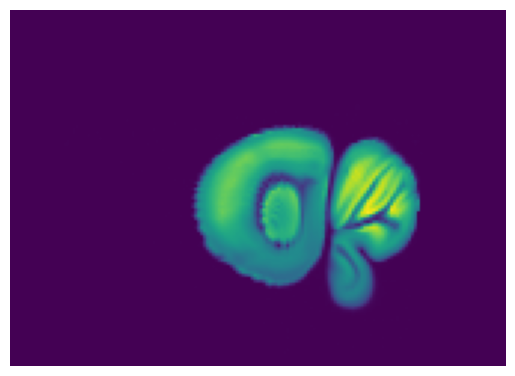

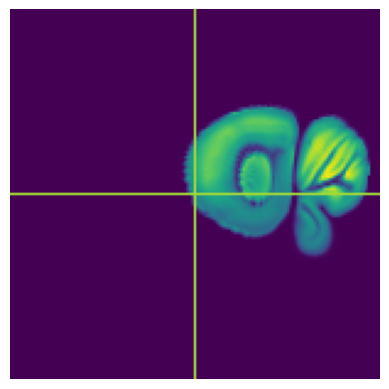

In [147]:
offset, pitch, yaw = 50, 20, 20
simulate(offset, pitch, yaw)

a, b, d, c = display_plane.points

A, _, D, C = find_corners(plane_mesh)

if orientation == Orientation.SAGITTAL:
    # Mimic vedo rotation
    display_plane.rotate(
        signed_vector_angle(a - d, A - D, normal),
        axis=Rotation.from_euler("XY", [pitch, yaw], degrees=True).apply([0, 0, 1]),
        point=origin,
    )
    a, b, d, c = display_plane.points

e = euclidean(a, A)
e_prime = euclidean(c, C)

theta = signed_vector_angle(A - a, a - d, normal)
theta_prime = signed_vector_angle(C - c, b - c, normal)

x, y, x_prime, y_prime = extract_values(e, theta, e_prime, theta_prime)

print(f"{offset=}, {pitch=}, {yaw=}")
print(f"{e=}, {theta=}, {e_prime=}, {theta_prime=}")
print(f"{x=}, {y=}, {x_prime=}, {y_prime=}")

image = (
    plane_mesh.pointdata["ImageScalars"].reshape(plane_mesh.metadata["shape"]).copy()
)

# cropping = [
#     y if y > 0 else 0,
#     image.shape[0] - (-y_prime if y_prime < 0 else 0),
#     x if x > 0 else 0,
#     image.shape[1] - (-x_prime if x_prime < 0 else 0),
# ]
# padding = [
#     [
#         -y if y < 0 else 0,
#         y_prime if y_prime > 0 else 0,
#     ],
#     [
#         -x if x < 0 else 0,
#         x_prime if x_prime > 0 else 0,
#     ],
# ]
# cropping = [
#     -x_prime if x_prime < 0 else 0,
#     image.shape[0] - (x if x > 0 else 0),
#     -y_prime if y_prime < 0 else 0,
#     image.shape[1] - (y if y > 0 else 0),
# ]
# padding = [
#     [
#         x_prime if x_prime > 0 else 0,
#         -x if x < 0 else 0,
#     ],
#     [
#         y_prime if y_prime > 0 else 0,
#         -y if y < 0 else 0,
#     ],
# ]
cropping = [
    x if x > 0 else 0,
    image.shape[0] - (-x_prime if x_prime < 0 else 0),
    y if y > 0 else 0,
    image.shape[1] - (-y_prime if y_prime < 0 else 0),
]
padding = [
    [
        -x if x < 0 else 0,
        x_prime if x_prime > 0 else 0,
    ],
    [
        -y if y < 0 else 0,
        y_prime if y_prime > 0 else 0,
    ],
]

cropped = image[cropping[0] : cropping[1], cropping[2] : cropping[3]]
padded = np.pad(cropped, padding)

# image = rotate(image, pitch, reshape=False)
rotated = padded
if orientation == Orientation.CORONAL:
    rotated = rotate(padded, pitch, reshape=False)
elif orientation == Orientation.HORIZONTAL:
    rotated = rotate(padded, pitch - 90, reshape=False)
# rotated = padded

# image[(image.shape[0] - 1) // 2] = 255
# image[..., (image.shape[1] - 1) // 2] = 255

rotated[(rotated.shape[0] - 1) // 2] = 255
rotated[..., (rotated.shape[1] - 1) // 2] = 255

print(f"Original:       {tuple(plane_mesh.metadata['shape'])}")
print(f"After crop:     {cropped.shape}")
print(f"After padding:  {padded.shape}")
print(f"After rotation: {rotated.shape}")

print(signed_vector_angle(a - d, A - D, normal))

# print(rotate(reference_image, pitch, reshape=False).shape)
# print(image.shape)
# print(rotated.shape)

imshow(plane_mesh.pointdata["ImageScalars"].reshape(plane_mesh.metadata["shape"]))
# imshow(rotate(reference_image, pitch, reshape=False))
# imshow(image)
imshow(rotated)

In [148]:
camera = dict(
    position=(-400, 40, 80),
    focal_point=origin,
    viewup=(0, 0, 1),
    roll=90,
)

show(
    [
        # vedo.Point(a, c="red", r=10),
        # vedo.Point(c, c="white", r=10),
        vedo.Point(C, c="black", r=10),
        vedo.Arrow(d, a, c="red", s=0.1),
        vedo.Arrow(c, b, c="blue", s=0.1),
        vedo.Arrow(a, A, c="orange", s=0.1),
        vedo.Arrow(c, C, c="cyan", s=0.1),
        volume,
        plane_mesh,
        display_plane,
    ],
    camera=camera,
)

In [146]:
params = [0, 0, 0]


def offset_slider(widget, event):
    params[0] = widget.value
    populate_plotter()


def pitch_slider(widget, event):
    params[1] = widget.value
    populate_plotter()


def yaw_slider(widget, event):
    params[2] = widget.value
    populate_plotter()


def populate_plotter() -> None:
    global plotter

    simulate(*params)
    points = extract_significant_points(display_plane)

    plotter.clear()

    plotter += vedo.Points(display_plane.points, r=10, c="red")
    plotter += vedo.Point(points[0], r=15, c="cyan")
    plotter += vedo.Point(points[1], r=15, c="grey")

    plotter += display_plane.copy().alpha(0.5)
    plotter += plane_mesh.copy()
    plotter += volume
    # plotter += vedo.Box(target_plane.bounds()).alpha(0.3)


plotter = vedo.Plotter(axes=4)

plotter.add_slider(
    offset_slider,
    xmin=-90,
    xmax=90,
    value=0,
    pos="top-left",
)
plotter.add_slider(
    pitch_slider,
    xmin=-90,
    xmax=90,
    value=0,
    pos="bottom-left",
)
plotter.add_slider(
    yaw_slider,
    xmin=-90,
    xmax=90,
    value=0,
    pos="bottom-right",
)

populate_plotter()

plotter.show(interactive=False).interactive().close()